# Abstract "Translation"
In the original project, I trained a sequence to sequence model on a dataset of English and French sentences that can translate new sentences from English to French. This notebook was modified such that abstracts became the English text and the titles became the French text. The abstracts are defined as the source_text and the titles are defined as the target_text
## Get the Data
The data comes from the discovery set made by Roxana and Diego. The abstracts and titles were further cleaned as shown in another notebook.

In [1]:
import pandas as pd
data = pd.read_csv('arxiv_ep_cleaner_abstracts_titles.csv')

In [2]:
abstracts = data.abstracts #helper.load_data(source_path)
titles = data.titles #helper.load_data(target_path)

with open('titles.txt', 'w+') as file:
    for title in titles:
        file.write(title+'\n')
    file.close()
    
with open('abstracts.txt', 'w+') as file:
    for abstract in abstracts:
        file.write(abstract+'\n')
    file.close()

In [3]:
import helper
import problem_unittests as tests
source_path = 'abstracts.txt'
target_path = 'titles.txt'
source_text = helper.load_data(source_path)
target_text = helper.load_data(target_path)


## Explore the Data
Feel free to play around with view_sentence_range to view different parts of the data.

In [4]:
view_sentence_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in source_text.split()})))

sentences = source_text.split('\n')
word_counts = [len(sentence.split()) for sentence in sentences]
print('Number of abstracts: {}'.format(len(sentences)))
print('Average number of words in an abstract: {}'.format(np.average(word_counts)))

print()
print('Abstracts {} to {}:'.format(*view_sentence_range))
print('\n'.join(source_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))
print()
print('Titles {} to {}:'.format(*view_sentence_range))
print('\n'.join(target_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

Dataset Stats
Roughly the number of unique words: 31359
Number of abstracts: 13518
Average number of words in an abstract: 202.5818168368102

Abstracts 0 to 10:
water rich planet such a earth are expect to becom eventu uninhabitable, becaus liquid water doe not remain stabl at the surfac a surfac temperatur increas with the solar luminos over time whether a larg increas of atmospher concentr of greenhous ga such a co could also destroy the habit of water rich planet ha remain unclear we show with three dimension aqua planet numer experi that co induc forc a readili destabil the climat a doe solar forc the climat instabl is caus by a posit cloud feedback the climat doe not run away, but instead attain a new steadi state with global mean sea surfac temperatur abov k the upper atmospher is consider moister in thi warm steadi state than in the refer climate, impli that the planet would be subject to substanti loss of water to space for either a certain rang of elev co concentr or solar irr

## Implement Preprocessing Function
### Text to Word Ids
As you did with other RNNs, you must turn the text into a number so the computer can understand it. In the function `text_to_ids()`, you'll turn `source_text` and `target_text` from words to ids.  However, you need to add the `<EOS>` word id at the end of `target_text`.  This will help the neural network predict when the sentence should end.

You can get the `<EOS>` word id by doing:
```python
target_vocab_to_int['<EOS>']
```
You can get other word ids using `source_vocab_to_int` and `target_vocab_to_int`.

In [5]:
def text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int):
    """
    Convert source and target text to proper word ids
    :param source_text: String that contains all the source text.
    :param target_text: String that contains all the target text.
    :param source_vocab_to_int: Dictionary to go from the source words to an id
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: A tuple of lists (source_id_text, target_id_text)
    """
    # TODO: Implement Function
    source_id_text = [[source_vocab_to_int[word] for word in sentence.split()] \
                      for sentence in source_text.split('\n')] 
    target_id_text = [[target_vocab_to_int[word] for word in sentence.split()] + [target_vocab_to_int['<EOS>']] \
                      for sentence in target_text.split('\n')]
    return source_id_text, target_id_text

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_text_to_ids(text_to_ids)

Tests Passed


### Preprocess all the data and save it
Running the code cell below will preprocess all the data and save it to file.

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
helper.preprocess_and_save_data(source_path, target_path, text_to_ids)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import helper

(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
from tensorflow.python.layers.core import Dense

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.1'), 'Please use TensorFlow version 1.1 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


## Build the Neural Network
You'll build the components necessary to build a Sequence-to-Sequence model by implementing the following functions below:
- `model_inputs`
- `process_decoder_input`
- `encoding_layer`
- `decoding_layer_train`
- `decoding_layer_infer`
- `decoding_layer`
- `seq2seq_model`

### Input
Implement the `model_inputs()` function to create TF Placeholders for the Neural Network. It should create the following placeholders:

- Input text placeholder named "input" using the TF Placeholder name parameter with rank 2.
- Targets placeholder with rank 2.
- Learning rate placeholder with rank 0.
- Keep probability placeholder named "keep_prob" using the TF Placeholder name parameter with rank 0.
- Target sequence length placeholder named "target_sequence_length" with rank 1
- Max target sequence length tensor named "max_target_len" getting its value from applying tf.reduce_max on the target_sequence_length placeholder. Rank 0.
- Source sequence length placeholder named "source_sequence_length" with rank 1

Return the placeholders in the following the tuple (input, targets, learning rate, keep probability, target sequence length, max target sequence length, source sequence length)

In [9]:
def model_inputs():
    """
    Create TF Placeholders for input, targets, learning rate, and lengths of source and target sequences.
    :return: Tuple (input, targets, learning rate, keep probability, target sequence length,
    max target sequence length, source sequence length)
    """
    inputs = tf.placeholder(tf.int32, [None, None], name='input')
    
    targets = tf.placeholder(tf.int32, [None, None])
    
    learning_rate = tf.placeholder(tf.float32)
    
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    target_sequence_length = tf.placeholder(tf.int32, [None], name='target_sequence_length')
    
    max_target_len = tf.reduce_max(target_sequence_length, name='max_target_len')
    
    source_sequence_length = tf.placeholder(tf.int32, [None],name='source_sequence_length')
    
    return inputs, targets, learning_rate, keep_prob, target_sequence_length, max_target_len, source_sequence_length


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Process Decoder Input
Implement `process_decoder_input` by removing the last word id from each batch in `target_data` and concat the GO ID to the begining of each batch.

In [10]:
def process_decoder_input(target_data, target_vocab_to_int, batch_size):
    """
    Preprocess target data for encoding
    :param target_data: Target Placehoder
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param batch_size: Batch Size
    :return: Preprocessed target data
    """
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    
    proc_input = tf.concat([tf.fill([batch_size, 1], target_vocab_to_int['<GO>']), ending], 1)
    
    return proc_input

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_process_encoding_input(process_decoder_input)

Tests Passed


### Encoding
Implement `encoding_layer()` to create a Encoder RNN layer:
 * Embed the encoder input using [`tf.contrib.layers.embed_sequence`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence)
 * Construct a [stacked](https://github.com/tensorflow/tensorflow/blob/6947f65a374ebf29e74bb71e36fd82760056d82c/tensorflow/docs_src/tutorials/recurrent.md#stacking-multiple-lstms) [`tf.contrib.rnn.LSTMCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/LSTMCell) wrapped in a [`tf.contrib.rnn.DropoutWrapper`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/DropoutWrapper)
 * Pass cell and embedded input to [`tf.nn.dynamic_rnn()`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn)

In [11]:
from imp import reload
reload(tests)

def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob, 
                   source_sequence_length, source_vocab_size, 
                   encoding_embedding_size):
    """
    Create encoding layer
    :param rnn_inputs: Inputs for the RNN
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param keep_prob: Dropout keep probability
    :param source_sequence_length: a list of the lengths of each sequence in the batch
    :param source_vocab_size: vocabulary size of source data
    :param encoding_embedding_size: embedding size of source data
    :return: tuple (RNN output, RNN state)
    """
    embedded_input = tf.contrib.layers.embed_sequence(rnn_inputs, 
                                                      source_vocab_size, 
                                                      encoding_embedding_size)
    
    cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnn_size) \
                                        for _ in range(num_layers)])
    
    cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    
    output, state = tf.nn.dynamic_rnn(cell, embedded_input, 
                                      sequence_length=source_sequence_length, dtype=tf.float32)
    
    return output, state

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_encoding_layer(encoding_layer)

Tests Passed


### Decoding - Training
Create a training decoding layer:
* Create a [`tf.contrib.seq2seq.TrainingHelper`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/TrainingHelper) 
* Create a [`tf.contrib.seq2seq.BasicDecoder`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BasicDecoder)
* Obtain the decoder outputs from [`tf.contrib.seq2seq.dynamic_decode`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_decode)

In [12]:

def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, 
                         target_sequence_length, max_summary_length, 
                         output_layer, keep_prob):
    """
    Create a decoding layer for training
    :param encoder_state: Encoder State
    :param dec_cell: Decoder RNN Cell
    :param dec_embed_input: Decoder embedded input
    :param target_sequence_length: The lengths of each sequence in the target batch
    :param max_summary_length: The length of the longest sequence in the batch
    :param output_layer: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: BasicDecoderOutput containing training logits and sample_id
    """
    ##1. Apply TrainingHelper
    train_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input,
                                                    sequence_length=target_sequence_length,
                                                    time_major=False)
    
    ##2. Apply BasicDecoder
    train_decode = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                 train_helper,
                                                 encoder_state,
                                                 output_layer)
    
    ##3. Apply dynamic_decode
    train_decode_output, _ = tf.contrib.seq2seq.dynamic_decode(train_decode,
                                                              impute_finished=True,
                                                              maximum_iterations=max_summary_length)
    
    return train_decode_output



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_train(decoding_layer_train)

Tests Passed


### Decoding - Inference
Create inference decoder:
* Create a [`tf.contrib.seq2seq.GreedyEmbeddingHelper`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/GreedyEmbeddingHelper)
* Create a [`tf.contrib.seq2seq.BasicDecoder`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BasicDecoder)
* Obtain the decoder outputs from [`tf.contrib.seq2seq.dynamic_decode`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_decode)

In [13]:
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id,
                         end_of_sequence_id, max_target_sequence_length,
                         vocab_size, output_layer, batch_size, keep_prob):
    """
    Create a decoding layer for inference
    :param encoder_state: Encoder state
    :param dec_cell: Decoder RNN Cell
    :param dec_embeddings: Decoder embeddings
    :param start_of_sequence_id: GO ID
    :param end_of_sequence_id: EOS Id
    :param max_target_sequence_length: Maximum length of target sequences
    :param vocab_size: Size of decoder/target vocabulary
    :param decoding_scope: TenorFlow Variable Scope for decoding
    :param output_layer: Function to apply the output layer
    :param batch_size: Batch size
    :param keep_prob: Dropout keep probability
    :return: BasicDecoderOutput containing inference logits and sample_id
    """
    ##O. Create start tokens
    start_tokens = tf.tile(tf.constant([start_of_sequence_id], dtype=tf.int32),
                          [batch_size], name='start_tokens')
    
    ##1. Apply GreedyEmbeddingHelper
    infer_help = tf.contrib.seq2seq.GreedyEmbeddingHelper(dec_embeddings,
                                                         start_tokens,
                                                         end_of_sequence_id)
    
    ##2. Apply BasicDecoder
    infer_decode = tf.contrib.seq2seq.BasicDecoder(dec_cell, infer_help,
                                                  encoder_state, output_layer)
    
    ##3. Apply dynamic_decode
    infer_decode_output, _ = tf.contrib.seq2seq.dynamic_decode(infer_decode,
                                                              impute_finished=True,
                                                              maximum_iterations=max_target_sequence_length)
    
    return infer_decode_output



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_infer(decoding_layer_infer)

Tests Passed


### Build the Decoding Layer
Implement `decoding_layer()` to create a Decoder RNN layer.

* Embed the target sequences
* Construct the decoder LSTM cell (just like you constructed the encoder cell above)
* Create an output layer to map the outputs of the decoder to the elements of our vocabulary
* Use the your `decoding_layer_train(encoder_state, dec_cell, dec_embed_input, target_sequence_length, max_target_sequence_length, output_layer, keep_prob)` function to get the training logits.
* Use your `decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id, max_target_sequence_length, vocab_size, output_layer, batch_size, keep_prob)` function to get the inference logits.

Note: You'll need to use [tf.variable_scope](https://www.tensorflow.org/api_docs/python/tf/variable_scope) to share variables between training and inference.

In [16]:
def decoding_layer(dec_input, encoder_state,
                   target_sequence_length, max_target_sequence_length,
                   rnn_size,
                   num_layers, target_vocab_to_int, target_vocab_size,
                   batch_size, keep_prob, decoding_embedding_size):
    """
    Create decoding layer
    :param dec_input: Decoder input
    :param encoder_state: Encoder state
    :param target_sequence_length: The lengths of each sequence in the target batch
    :param max_target_sequence_length: Maximum length of target sequences
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param target_vocab_size: Size of target vocabulary
    :param batch_size: The size of the batch
    :param keep_prob: Dropout keep probability
    :param decoding_embedding_size: Decoding embedding size
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    ##1. Embedded the target sequence
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, dec_input)
    
    ##2. Construct LSTM Cell
    dec_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnn_size) \
                                            for _ in range(num_layers)])
    
    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, output_keep_prob=keep_prob)
    
    ##3. Create mapping outpult layer
    output_layer = Dense(target_vocab_size, 
                       kernel_initializer = tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
    
    ##4. Do the decoding for training and inference
    with tf.variable_scope('decode'):
        train_decode_output = decoding_layer_train(encoder_state, dec_cell, dec_embed_input, 
                                                  target_sequence_length, max_target_sequence_length, 
                                                  output_layer, keep_prob)
        
    with tf.variable_scope('decode', reuse=True):
        infer_decode_output = decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, 
                                                  target_vocab_to_int['<GO>'], 
                                                  target_vocab_to_int['<EOS>'], 
                                                  max_target_sequence_length, target_vocab_size, output_layer, 
                                                  batch_size, keep_prob)
    
    return train_decode_output, infer_decode_output, dec_embeddings



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#tests.test_decoding_layer(decoding_layer)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

### Build the Neural Network
Apply the functions you implemented above to:

- Encode the input using your `encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob,  source_sequence_length, source_vocab_size, encoding_embedding_size)`.
- Process target data using your `process_decoder_input(target_data, target_vocab_to_int, batch_size)` function.
- Decode the encoded input using your `decoding_layer(dec_input, enc_state, target_sequence_length, max_target_sentence_length, rnn_size, num_layers, target_vocab_to_int, target_vocab_size, batch_size, keep_prob, dec_embedding_size)` function.

In [17]:
def seq2seq_model(input_data, target_data, keep_prob, batch_size,
                  source_sequence_length, target_sequence_length,
                  max_target_sentence_length,
                  source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size,
                  rnn_size, num_layers, target_vocab_to_int):
    """
    Build the Sequence-to-Sequence part of the neural network
    :param input_data: Input placeholder
    :param target_data: Target placeholder
    :param keep_prob: Dropout keep probability placeholder
    :param batch_size: Batch Size
    :param source_sequence_length: Sequence Lengths of source sequences in the batch
    :param target_sequence_length: Sequence Lengths of target sequences in the batch
    :param source_vocab_size: Source vocabulary size
    :param target_vocab_size: Target vocabulary size
    :param enc_embedding_size: Decoder embedding size
    :param dec_embedding_size: Encoder embedding size
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    ##1. Encode input using enconding_layer()
    _, enc_input = encoding_layer(input_data, rnn_size, num_layers, keep_prob,  
                                   source_sequence_length, source_vocab_size, 
                                   enc_embedding_size)
    
    ##2. Process target data with procesed_decoder_input()
    dec_input = process_decoder_input(target_data, target_vocab_to_int, batch_size)
    
    ##3. Decode input using decoding_layer
    train_output, infer_output, dec_embeddings = decoding_layer(dec_input, enc_input, target_sequence_length, 
                                                max_target_sentence_length, rnn_size, num_layers, 
                                                target_vocab_to_int, target_vocab_size, batch_size, 
                                                keep_prob, dec_embedding_size)
    
    return train_output, infer_output, dec_embeddings


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#tests.test_seq2seq_model(seq2seq_model)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

## Neural Network Training
### Hyperparameters
Tune the following parameters:

- Set `epochs` to the number of epochs.
- Set `batch_size` to the batch size.
- Set `rnn_size` to the size of the RNNs.
- Set `num_layers` to the number of layers.
- Set `encoding_embedding_size` to the size of the embedding for the encoder.
- Set `decoding_embedding_size` to the size of the embedding for the decoder.
- Set `learning_rate` to the learning rate.
- Set `keep_probability` to the Dropout keep probability
- Set `display_step` to state how many steps between each debug output statement

In [22]:
# Number of Epochs
epochs = 48
# Batch Size
batch_size = 128
# RNN Size
rnn_size = 300
# Number of Layers
num_layers = 4
# Embedding Size
encoding_embedding_size = 300
decoding_embedding_size = 300
# Learning Rate
learning_rate = 0.001
# Dropout Keep Probability
keep_probability = 0.8
display_step = 10

### Build the Graph
Build the graph using the neural network you implemented.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_path = 'checkpoints/dev'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()
max_target_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, lr, keep_prob, target_sequence_length, max_target_sequence_length, source_sequence_length = model_inputs()

    #sequence_length = tf.placeholder_with_default(max_target_sentence_length, None, name='sequence_length')
    input_shape = tf.shape(input_data)

    train_logits, inference_logits, dec_embeddings = seq2seq_model(tf.reverse(input_data, [-1]),
                                                   targets,
                                                   keep_prob,
                                                   batch_size,
                                                   source_sequence_length,
                                                   target_sequence_length,
                                                   max_target_sequence_length,
                                                   len(source_vocab_to_int),
                                                   len(target_vocab_to_int),
                                                   encoding_embedding_size,
                                                   decoding_embedding_size,
                                                   rnn_size,
                                                   num_layers,
                                                   target_vocab_to_int)


    training_logits = tf.identity(train_logits.rnn_output, name='logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')

    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)


Batch and pad the source and target sequences

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
def pad_sentence_batch(sentence_batch, pad_int):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [pad_int] * (max_sentence - len(sentence)) for sentence in sentence_batch]


def get_batches(sources, targets, batch_size, source_pad_int, target_pad_int):
    """Batch targets, sources, and the lengths of their sentences together"""
    for batch_i in range(0, len(sources)//batch_size):
        start_i = batch_i * batch_size

        # Slice the right amount for the batch
        sources_batch = sources[start_i:start_i + batch_size]
        targets_batch = targets[start_i:start_i + batch_size]

        # Pad
        pad_sources_batch = np.array(pad_sentence_batch(sources_batch, source_pad_int))
        pad_targets_batch = np.array(pad_sentence_batch(targets_batch, target_pad_int))

        # Need the lengths for the _lengths parameters
        pad_targets_lengths = []
        for target in pad_targets_batch:
            pad_targets_lengths.append(len(target))

        pad_source_lengths = []
        for source in pad_sources_batch:
            pad_source_lengths.append(len(source))

        yield pad_sources_batch, pad_targets_batch, pad_source_lengths, pad_targets_lengths


### Train
Train the neural network on the preprocessed data. If you have a hard time getting a good loss, check the forms to see if anyone is having the same problem.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1])],
            'constant')

    return np.mean(np.equal(target, logits))

# Split data to training and validation sets
train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]
valid_source = source_int_text[:batch_size]
valid_target = target_int_text[:batch_size]
(valid_sources_batch, valid_targets_batch, valid_sources_lengths, valid_targets_lengths ) = next(get_batches(valid_source,
                                                                                                             valid_target,
                                                                                                             batch_size,
                                                                                                             source_vocab_to_int['<PAD>'],
                                                                                                             target_vocab_to_int['<PAD>']))                                                                                                  
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        for batch_i, (source_batch, target_batch, sources_lengths, targets_lengths) in enumerate(
                get_batches(train_source, train_target, batch_size,
                            source_vocab_to_int['<PAD>'],
                            target_vocab_to_int['<PAD>'])):

            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 target_sequence_length: targets_lengths,
                 source_sequence_length: sources_lengths,
                 keep_prob: keep_probability})


            if batch_i % display_step == 0 and batch_i > 0:


                batch_train_logits = sess.run(
                    inference_logits,
                    {input_data: source_batch,
                     source_sequence_length: sources_lengths,
                     target_sequence_length: targets_lengths,
                     keep_prob: 1.0})


                batch_valid_logits = sess.run(
                    inference_logits,
                    {input_data: valid_sources_batch,
                     source_sequence_length: valid_sources_lengths,
                     target_sequence_length: valid_targets_lengths,
                     keep_prob: 1.0})

                train_acc = get_accuracy(target_batch, batch_train_logits)

                valid_acc = get_accuracy(valid_targets_batch, batch_valid_logits)

                print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.4f}, Validation Accuracy: {:>6.4f}, Loss: {:>6.4f}'
                      .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('Model Trained and Saved')

Epoch   0 Batch   10/105 - Train Accuracy: 0.4535, Validation Accuracy: 0.4991, Loss: 4.7442
Epoch   0 Batch   20/105 - Train Accuracy: 0.5527, Validation Accuracy: 0.5006, Loss: 3.3862
Epoch   0 Batch   30/105 - Train Accuracy: 0.5290, Validation Accuracy: 0.5022, Loss: 3.3829
Epoch   0 Batch   40/105 - Train Accuracy: 0.5689, Validation Accuracy: 0.5069, Loss: 3.0427
Epoch   0 Batch   50/105 - Train Accuracy: 0.5751, Validation Accuracy: 0.5078, Loss: 2.9577
Epoch   0 Batch   60/105 - Train Accuracy: 0.4973, Validation Accuracy: 0.5069, Loss: 3.4904
Epoch   0 Batch   70/105 - Train Accuracy: 0.5485, Validation Accuracy: 0.5075, Loss: 3.2554
Epoch   0 Batch   80/105 - Train Accuracy: 0.5644, Validation Accuracy: 0.5062, Loss: 3.0695
Epoch   0 Batch   90/105 - Train Accuracy: 0.5009, Validation Accuracy: 0.5041, Loss: 3.4946
Epoch   0 Batch  100/105 - Train Accuracy: 0.5625, Validation Accuracy: 0.5075, Loss: 3.1816
Epoch   1 Batch   10/105 - Train Accuracy: 0.4627, Validation Accuracy

Epoch   8 Batch  100/105 - Train Accuracy: 0.5469, Validation Accuracy: 0.4659, Loss: 2.4901
Epoch   9 Batch   10/105 - Train Accuracy: 0.4329, Validation Accuracy: 0.4678, Loss: 2.9552
Epoch   9 Batch   20/105 - Train Accuracy: 0.4873, Validation Accuracy: 0.4350, Loss: 2.4330
Epoch   9 Batch   30/105 - Train Accuracy: 0.5010, Validation Accuracy: 0.4828, Loss: 2.4813
Epoch   9 Batch   40/105 - Train Accuracy: 0.5435, Validation Accuracy: 0.4797, Loss: 2.2936
Epoch   9 Batch   50/105 - Train Accuracy: 0.5533, Validation Accuracy: 0.4725, Loss: 2.1588
Epoch   9 Batch   60/105 - Train Accuracy: 0.4787, Validation Accuracy: 0.4750, Loss: 2.6207
Epoch   9 Batch   70/105 - Train Accuracy: 0.5245, Validation Accuracy: 0.4575, Loss: 2.4787
Epoch   9 Batch   80/105 - Train Accuracy: 0.5428, Validation Accuracy: 0.4694, Loss: 2.2513
Epoch   9 Batch   90/105 - Train Accuracy: 0.4797, Validation Accuracy: 0.4700, Loss: 2.6283
Epoch   9 Batch  100/105 - Train Accuracy: 0.5388, Validation Accuracy

Epoch  17 Batch   90/105 - Train Accuracy: 0.4553, Validation Accuracy: 0.4469, Loss: 2.2932
Epoch  17 Batch  100/105 - Train Accuracy: 0.5098, Validation Accuracy: 0.4434, Loss: 2.1961
Epoch  18 Batch   10/105 - Train Accuracy: 0.4123, Validation Accuracy: 0.4494, Loss: 2.6009
Epoch  18 Batch   20/105 - Train Accuracy: 0.5252, Validation Accuracy: 0.4738, Loss: 2.1462
Epoch  18 Batch   30/105 - Train Accuracy: 0.5016, Validation Accuracy: 0.4716, Loss: 2.1360
Epoch  18 Batch   40/105 - Train Accuracy: 0.5388, Validation Accuracy: 0.4756, Loss: 1.9872
Epoch  18 Batch   50/105 - Train Accuracy: 0.5505, Validation Accuracy: 0.4681, Loss: 1.8631
Epoch  18 Batch   60/105 - Train Accuracy: 0.4612, Validation Accuracy: 0.4547, Loss: 2.2641
Epoch  18 Batch   70/105 - Train Accuracy: 0.5251, Validation Accuracy: 0.4544, Loss: 2.1795
Epoch  18 Batch   80/105 - Train Accuracy: 0.5286, Validation Accuracy: 0.4375, Loss: 2.0009
Epoch  18 Batch   90/105 - Train Accuracy: 0.4672, Validation Accuracy

Epoch  26 Batch   80/105 - Train Accuracy: 0.5463, Validation Accuracy: 0.4553, Loss: 1.7891
Epoch  26 Batch   90/105 - Train Accuracy: 0.4978, Validation Accuracy: 0.4531, Loss: 1.9738
Epoch  26 Batch  100/105 - Train Accuracy: 0.5452, Validation Accuracy: 0.4616, Loss: 1.9808
Epoch  27 Batch   10/105 - Train Accuracy: 0.4119, Validation Accuracy: 0.4462, Loss: 2.3117
Epoch  27 Batch   20/105 - Train Accuracy: 0.5295, Validation Accuracy: 0.4628, Loss: 1.9209
Epoch  27 Batch   30/105 - Train Accuracy: 0.5026, Validation Accuracy: 0.4681, Loss: 1.9366
Epoch  27 Batch   40/105 - Train Accuracy: 0.5421, Validation Accuracy: 0.4519, Loss: 1.8208
Epoch  27 Batch   50/105 - Train Accuracy: 0.5405, Validation Accuracy: 0.4584, Loss: 1.6902
Epoch  27 Batch   60/105 - Train Accuracy: 0.4669, Validation Accuracy: 0.4525, Loss: 2.0342
Epoch  27 Batch   70/105 - Train Accuracy: 0.5366, Validation Accuracy: 0.4728, Loss: 1.9350
Epoch  27 Batch   80/105 - Train Accuracy: 0.5558, Validation Accuracy

Epoch  35 Batch   70/105 - Train Accuracy: 0.5377, Validation Accuracy: 0.4709, Loss: 1.7680
Epoch  35 Batch   80/105 - Train Accuracy: 0.5517, Validation Accuracy: 0.4631, Loss: 1.5723
Epoch  35 Batch   90/105 - Train Accuracy: 0.4972, Validation Accuracy: 0.4816, Loss: 1.7404
Epoch  35 Batch  100/105 - Train Accuracy: 0.5304, Validation Accuracy: 0.4456, Loss: 1.7350
Epoch  36 Batch   10/105 - Train Accuracy: 0.4162, Validation Accuracy: 0.4553, Loss: 1.9476
Epoch  36 Batch   20/105 - Train Accuracy: 0.5344, Validation Accuracy: 0.4628, Loss: 1.6828
Epoch  36 Batch   30/105 - Train Accuracy: 0.5146, Validation Accuracy: 0.4656, Loss: 1.6527
Epoch  36 Batch   40/105 - Train Accuracy: 0.5441, Validation Accuracy: 0.4616, Loss: 1.6007
Epoch  36 Batch   50/105 - Train Accuracy: 0.5653, Validation Accuracy: 0.4587, Loss: 1.5184
Epoch  36 Batch   60/105 - Train Accuracy: 0.4724, Validation Accuracy: 0.4472, Loss: 1.8508
Epoch  36 Batch   70/105 - Train Accuracy: 0.5345, Validation Accuracy

Epoch  44 Batch   60/105 - Train Accuracy: 0.4937, Validation Accuracy: 0.4591, Loss: 1.6065
Epoch  44 Batch   70/105 - Train Accuracy: 0.5436, Validation Accuracy: 0.4678, Loss: 1.5765
Epoch  44 Batch   80/105 - Train Accuracy: 0.5552, Validation Accuracy: 0.4594, Loss: 1.4658
Epoch  44 Batch   90/105 - Train Accuracy: 0.5162, Validation Accuracy: 0.4709, Loss: 1.5518
Epoch  44 Batch  100/105 - Train Accuracy: 0.5564, Validation Accuracy: 0.4722, Loss: 1.5320
Epoch  45 Batch   10/105 - Train Accuracy: 0.4627, Validation Accuracy: 0.4672, Loss: 1.6800
Epoch  45 Batch   20/105 - Train Accuracy: 0.5440, Validation Accuracy: 0.4656, Loss: 1.4869
Epoch  45 Batch   30/105 - Train Accuracy: 0.5267, Validation Accuracy: 0.4709, Loss: 1.4436
Epoch  45 Batch   40/105 - Train Accuracy: 0.5717, Validation Accuracy: 0.4769, Loss: 1.4273
Epoch  45 Batch   50/105 - Train Accuracy: 0.5631, Validation Accuracy: 0.4813, Loss: 1.3155
Epoch  45 Batch   60/105 - Train Accuracy: 0.4925, Validation Accuracy

### Save Parameters
Save the `batch_size` and `save_path` parameters for inference.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Save parameters for checkpoint
helper.save_params(save_path)

# Checkpoint

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import tensorflow as tf
import numpy as np
import helper
import problem_unittests as tests

_, (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = helper.load_preprocess()
load_path = helper.load_params()

## Sentence to Sequence
To feed a sentence into the model for translation, you first need to preprocess it.  Implement the function `sentence_to_seq()` to preprocess new sentences.

- Convert the sentence to lowercase
- Convert words into ids using `vocab_to_int`
 - Convert words not in the vocabulary, to the `<UNK>` word id.

In [26]:
def sentence_to_seq(sentence, vocab_to_int):
    """
    Convert a sentence to a sequence of ids
    :param sentence: String
    :param vocab_to_int: Dictionary to go from the words to an id
    :return: List of word ids
    """
    # TODO: Implement Function
    sent = sentence.lower()
    words = sent.split()
        
    ##2. Convert words into ids 
    ids = [vocab_to_int.get(word, vocab_to_int['<UNK>']) for word in words]
    
    return list(ids)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_sentence_to_seq(sentence_to_seq)

Tests Passed


## Translate
This will translate `translate_sentence` from English to French.

In [27]:
abstracts = data.abstracts
titles = data.titles
indx = 0

In [28]:
translate_sentence = abstracts[indx]


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
    source_sequence_length = loaded_graph.get_tensor_by_name('source_sequence_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    translate_logits = sess.run(logits, {input_data: [translate_sentence]*batch_size,
                                         target_sequence_length: [len(translate_sentence)*2]*batch_size,
                                         source_sequence_length: [len(translate_sentence)]*batch_size,
                                         keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in translate_sentence]))
print('  Abstract: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in translate_logits]))
print('  Predicted Title: {}'.format(" ".join([target_int_to_vocab[i] for i in translate_logits])))


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


Input
  Word Ids:      [5811, 9314, 16477, 25032, 4670, 26353, 7746, 8082, 3739, 9253, 24016, 19929, 18334, 23792, 5811, 28588, 21639, 29134, 24018, 16669, 14298, 19362, 4670, 19362, 16536, 11141, 15708, 14298, 22216, 9474, 11921, 8510, 23670, 4670, 9340, 11141, 12191, 27912, 30555, 12191, 10435, 26496, 25032, 4670, 19105, 22559, 538, 9507, 14298, 28962, 12191, 5811, 9314, 16477, 17138, 29134, 22637, 20300, 12360, 15708, 5708, 20647, 26058, 16477, 9224, 3845, 30511, 19105, 23587, 27664, 4670, 26472, 30292, 14298, 5381, 4670, 28588, 22216, 27664, 14298, 5381, 9370, 1052, 7090, 12063, 4670, 26945, 17715, 704, 14298, 5381, 28588, 21639, 5528, 27088, 15193, 10764, 19010, 4670, 22961, 7072, 26470, 15708, 23219, 24906, 427, 19362, 16536, 9944, 18426, 14298, 7938, 27912, 1052, 20404, 24722, 22008, 23067, 2483, 7072, 26470, 25353, 22008, 14298, 19307, 11280, 15592, 30511, 14298, 16477, 18703, 7951, 10380, 3739, 24132, 29565, 12191, 5811, 3739, 2022, 13147, 4532, 4670, 19926, 6131, 12191, 11281

In [29]:
titles[0]

'transit to a moist greenhous with co and solar forc'

In [30]:
generated_titles = []
for abstract in abstracts:
    translate_sentence = abstract


    """
    DON'T MODIFY ANYTHING IN THIS CELL
    """
    translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        # Load saved model
        loader = tf.train.import_meta_graph(load_path + '.meta')
        loader.restore(sess, load_path)

        input_data = loaded_graph.get_tensor_by_name('input:0')
        logits = loaded_graph.get_tensor_by_name('predictions:0')
        target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
        source_sequence_length = loaded_graph.get_tensor_by_name('source_sequence_length:0')
        keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

        translate_logits = sess.run(logits, {input_data: [translate_sentence]*batch_size,
                                             target_sequence_length: [len(translate_sentence)*2]*batch_size,
                                             source_sequence_length: [len(translate_sentence)]*batch_size,
                                             keep_prob: 1.0})[0]

    #print('Input')
    #print('  Word Ids:      {}'.format([i for i in translate_sentence]))
    #print('  Abstract: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

    #print('\nPrediction')
    #print('  Word Ids:      {}'.format([i for i in translate_logits]))
    #print('  Predicted Title: {}'.format(" ".join([target_int_to_vocab[i] for i in translate_logits])))

    generated_titles.append(" ".join([target_int_to_vocab[i] for i in translate_logits]))

INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


In [31]:
# Create and save dataframe of original and generated titles
# Note the above cell was converted from code cell to markdown cell
df = pd.DataFrame({'original_titles': titles, 'generated_title': generated_titles})
df.to_csv('arxiv_ep_original_generated_titles.csv')
df.head()

generated_title  \
0  atmospher of the atmospher of the earth like p...   
1           dynam and dynam of asteroid famili <EOS>   
2  analyt model of the geodet blériot of the gali...   
3  the role of breccia chondrit in the solar syst...   
4  the surfac of the sun and the new space telesc...   

                                     original_titles  
0  transit to a moist greenhous with co and solar...  
1  the dynam environ of asteroid lutetia accord t...  
2  are there moonlet near the uranian alpha and b...  
3  mar sedimentari rock eros rate constrain use c...  
4  distribut of spin ax longitud and shape elong ...

INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


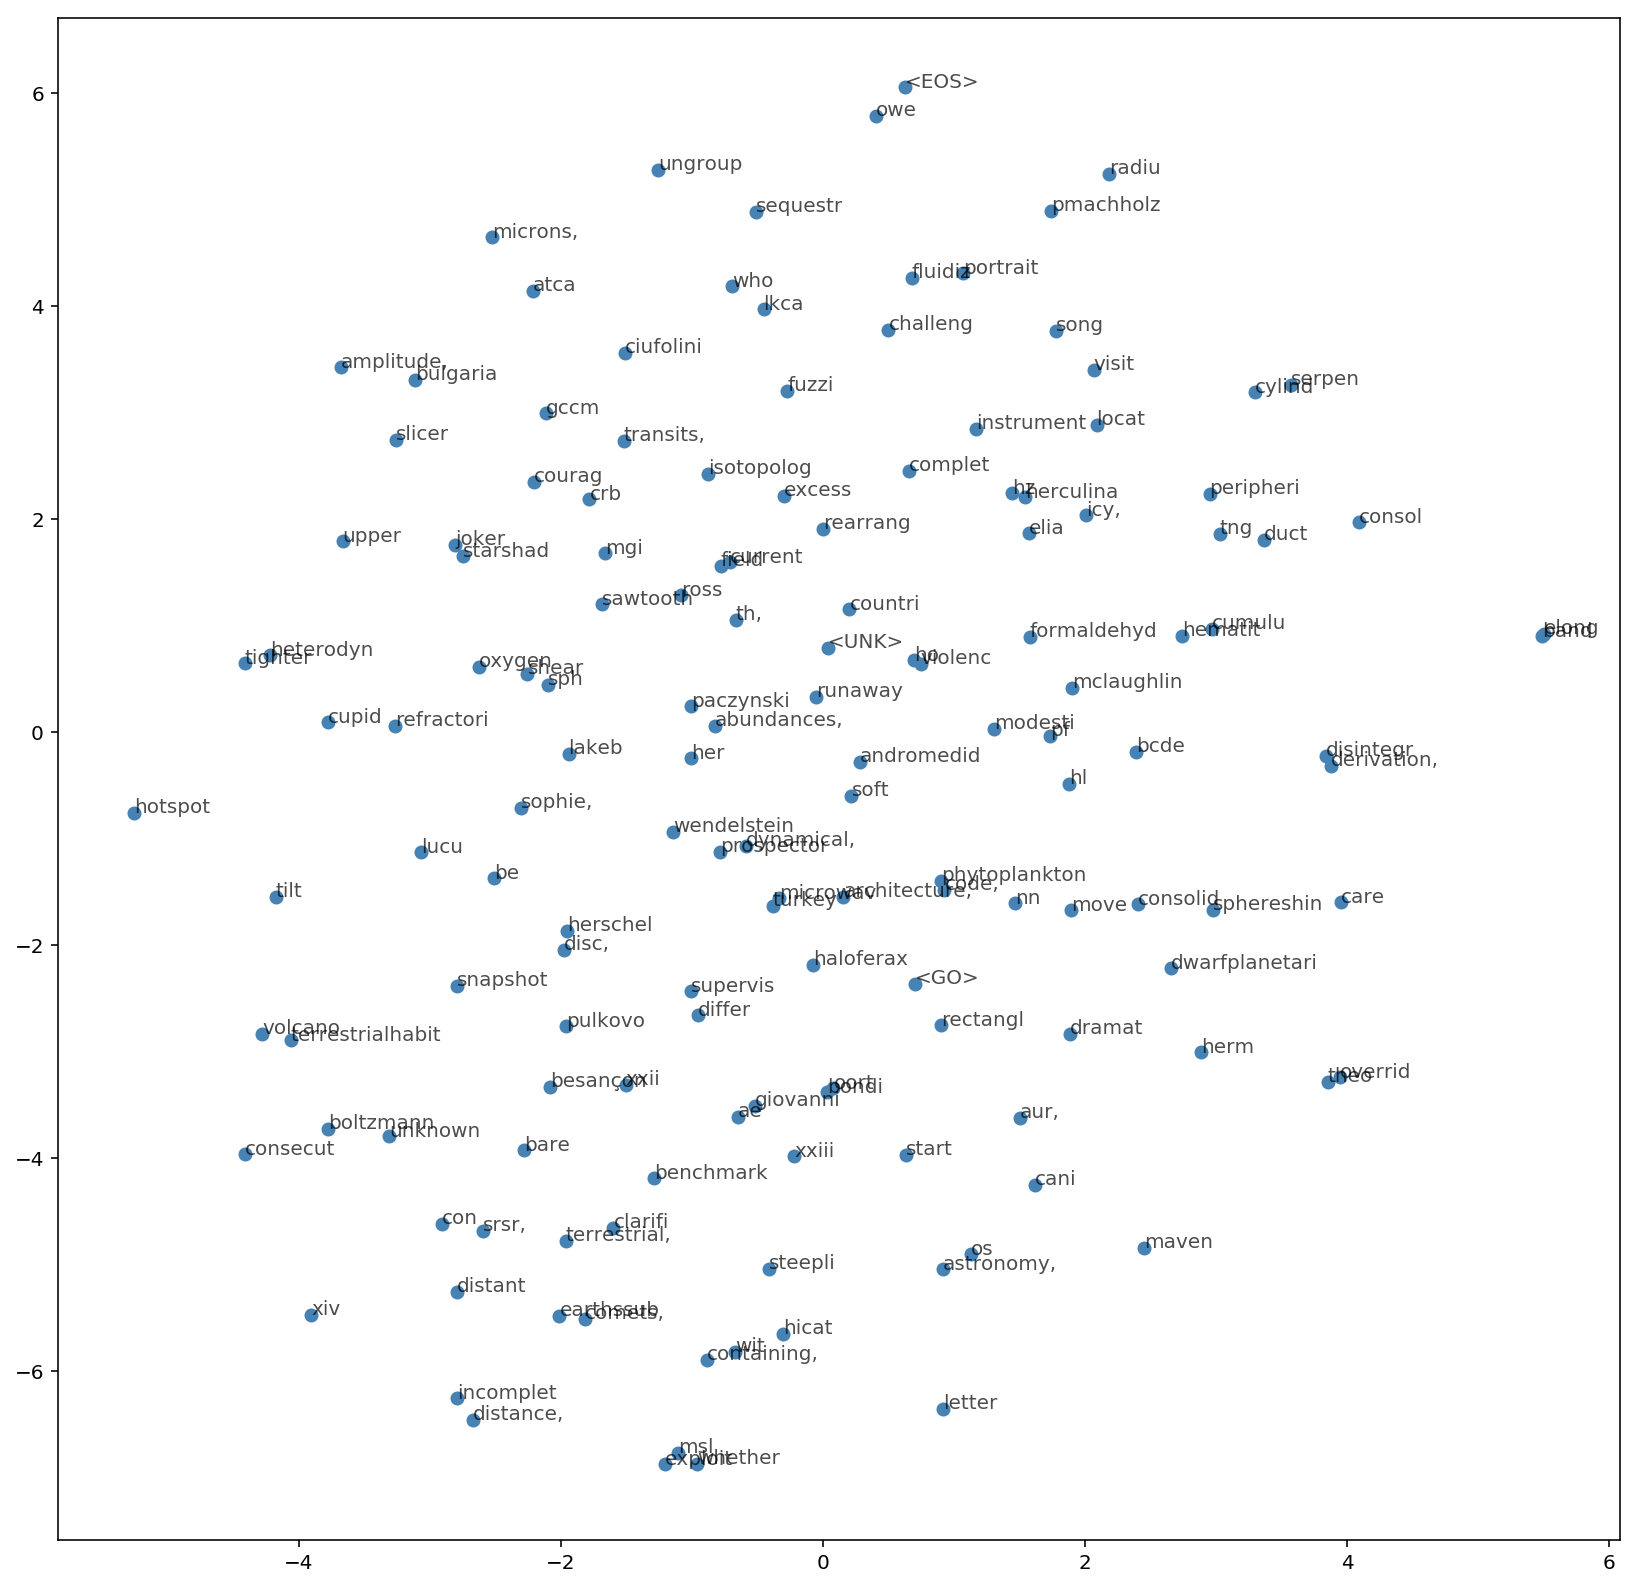

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
# Plot embedding matrix sample
with train_graph.as_default():
    saver = tf.train.Saver()
    
with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(dec_embeddings)

from sklearn.manifold import TSNE
viz_words = 150
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(1, viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(target_int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)